# SMU MSDS 6372 Advance Statistical Modeling - Project 1 

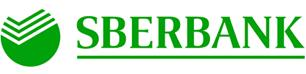

## Goal 1: Prediction of Individual Property Values

> __ABSTRACT__ 
The housing market in Russia is relatively stable, and contrary to mainstream knowledge on real estate, the value of a property is determined my more factors than the typical square area, number of floors/bathrooms and bedrooms. This report extends this belief to other factors using up to the available 291 explanatory variables to develop a set of advanced regression models that would best predict the price of an individual property in the Russia area. In collaboration with SBERBANK, enable buyers and sellers to make the most effective decisions during real estate business decisions. 

### Objective
Utilizing the provided `modleingData` _(train)_ and `projectionData` _(test)_, provide 3 candidate models that best predicts the individual property values `price_doc` _(response/target variable)_. One of the core metrics used to determine the best model is the model that minimized the __Root Mean Squared Logarithmic Error__ (RMSLE)


### Contents
This notebook primarly focuses on the data analysis and feature selection in preparation for statistical modeling:
1. Data Collection
2. Preprocessing and Data Cleaning
3. Exploratory Analysis _(correlation, VIF)_

----
### LASSO Model .... first try
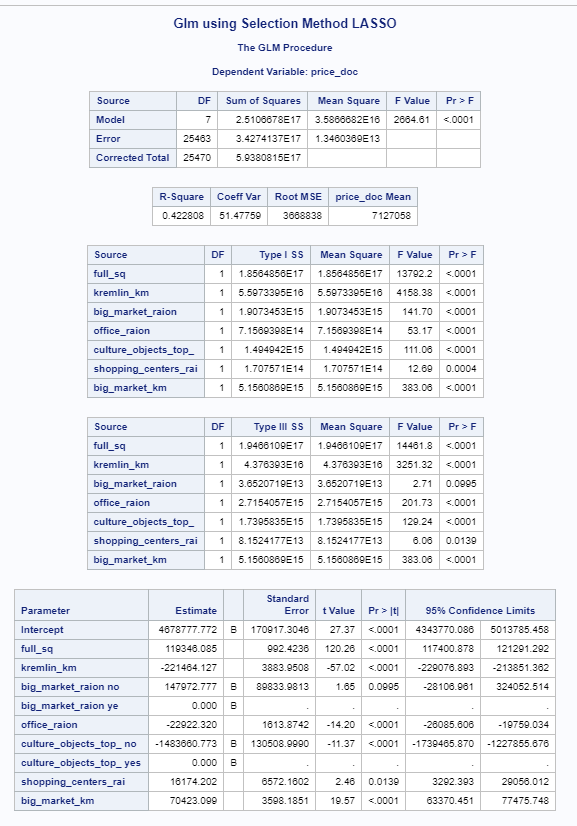


```sas
ods graphics on;
title "Glm using Selection Method LASSO";
proc glm data = dat plots=all;
	class big_market_raion culture_objects_top_25;
	model price_doc = full_sq kremlin_km big_market_raion office_raion culture_objects_top_25 shopping_centers_raion big_market_km/ tolerance solution clparm  ;
	output out = LASSO_output p=predict PRESS=CSVPress;
	
run;quit;ods graphics off;
```

In [264]:
!dir data

 Volume in drive C is OSDisk
 Volume Serial Number is DC78-EAF9

 Directory of C:\Users\phhale\OneDrive - Southern Methodist University\MSDS 6372 Applied Statistics\Project 1\data

06/01/2019  09:03 AM    <DIR>          .
06/01/2019  09:03 AM    <DIR>          ..
06/01/2019  09:03 AM    <DIR>          .ipynb_checkpoints
06/01/2019  09:03 AM                 0 sample_submission_.csv
               1 File(s)              0 bytes
               3 Dir(s)  26,760,429,568 bytes free


In [265]:
%%html
<div id="data"><p><iframe src="./data_dictionary.txt" frameborder="2" height="300"width="97%"></iframe></p></div>

__Import Libraries and required data sets__

In [305]:
import pandas as pd
import numpy as np

# Statistical Packages
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import plotting libraries
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# style
%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200, 'display.float_format', lambda x: '%.3f' % x)
sns.set(style='white', context='notebook', palette='deep')

In [306]:
train = pd.read_csv("./modelingData.csv")
test = pd.read_csv("./projectionData.csv")
train['flag'] = 'train'
test['flag'] = 'test'
train.head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1      40775       43   27.000  4.000        nan       nan         nan   
1   2      40778       34   19.000  3.000        nan       nan         nan   
2   3      40782       43   29.000  2.000        nan       nan         nan   
3   4      40787       89   50.000  9.000        nan       nan         nan   
4   5      40791       77   77.000  4.000        nan       nan         nan   

   num_room  kitch_sq  state product_type           sub_area       area_m  \
0       nan       nan    nan   Investment           Bibirevo  6407578.100   
1       nan       nan    nan   Investment  Nagatinskij Zaton  9589336.912   
2       nan       nan    nan   Investment     Tekstil'shhiki  4808269.831   
3       nan       nan    nan   Investment             Mitino 12583535.690   
4       nan       nan    nan   Investment          Basmannoe  8398460.622   

   raion_popul  green_zone_part  indust_part  children_preschool  \
0       155572            0.190        0.000                9576   
1       115352            0.373        0.050                6880   
2       101708            0.113        0.119                5879   
3       178473            0.195        0.070               13087   
4       108171            0.015        0.037                5706   

   preschool_quota  preschool_education_centers_raion  children_school  \
0         5001.000                                  5            10309   
1         3119.000                                  5             7759   
2         1463.000                                  4             6207   
3         6839.000                                  9            13670   
4         3240.000                                  7             6748   

   school_quota  school_education_centers_raion  \
0     11065.000                               5   
1      6237.000                               8   
2      5580.000                               7   
3     17063.000                              10   
4      7770.000                               9   

   school_education_centers_top_20_raion  hospital_beds_raion  \
0                                      0              240.000   
1                                      0              229.000   
2                                      0             1183.000   
3                                      0                  nan   
4                                      0              562.000   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   
1                         1                        0                    6   
2                         1                        0                    5   
3                         1                        0                   17   
4                         4                        2                   25   

   additional_education_raion culture_objects_top_25  \
0                           3                     no   
1                           1                    yes   
2                           1                     no   
3                           6                     no   
4                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   


In [307]:
print("Train data: ")
print("Training data Observations (rows): ", train.shape[0])
print("Training data Factors (columns): ", train.shape[1])
print("----------------------------------------------------")
print("Test data: ")
print("Test data Observations (rows): ", test.shape[0])
print("Test data Factors (columns): ", test.shape[1])

Train data: 
Training data Observations (rows):  25471
Training data Factors (columns):  293
----------------------------------------------------
Test data: 
Test data Observations (rows):  5000
Test data Factors (columns):  292


### Preliminary Summary Statistics and Data Analysis
In regards to the training below are some summary statistics

In [308]:
print("Number of properties: ", len(train))
print("Mean Property Price: ", str("$"), round(train.price_doc.mean(),0))
print("Highest Property Price: ", str("$"),train.price_doc.max())
print("Lowest Property Price: ", str("$"),train.price_doc.min())
print("Variability Property Price (standard dev): ", str("$"),round(train.price_doc.std(),0))

highest_area = train.groupby(['sub_area']).price_doc.mean().nlargest(1)
smallest_area = train.groupby(['sub_area']).price_doc.mean().nsmallest(1)
print(" ")
print("On Average, %s is the HIGHEST Property Sub Area with $ %d " % (highest_area.index[0], highest_area.values[0]))
print("On Average, %s is the LOWEST Property Sub Area with $ %d " % (smallest_area.index[0], smallest_area.values[0]))

Number of properties:  25471
Mean Property Price:  $ 7127058.0
Highest Property Price:  $ 111111112
Lowest Property Price:  $ 190000
Variability Property Price (standard dev):  $ 4828460.0
 
On Average, Hamovniki is the HIGHEST Property Sub Area with $ 21025307 
On Average, Poselenie Klenovskoe is the LOWEST Property Sub Area with $ 1000000 


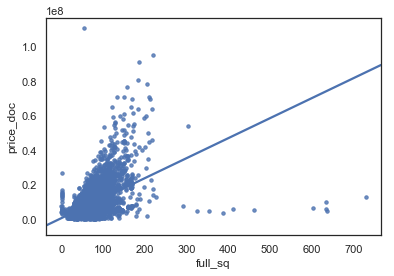

In [309]:
sns.regplot(x = 'full_sq', y='price_doc', data = train[train.full_sq<5000], 
           ci = None, scatter_kws={'color':'b', 's':12})

# train[train.full_sq<5000]

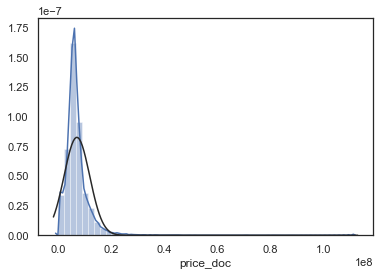

In [310]:
sns.distplot(train.price_doc, fit=norm);

* [x] Positive Skew
* [x] Tall peak

In [312]:
fig, ax =plt.subplots(1,2)

sns.distplot(train.price_doc, fit=norm, ax=ax[0])

sns.distplot(np.log(train.price_doc), fit=norm, ax=ax[1])
fig.show()

In [313]:
#check on the skew and kurtosis
print("Skewness: ", round(train.price_doc.skew(), 3))
print("Kurtosis: ", round(train.price_doc.kurt(), 3))

Skewness:  4.687
Kurtosis:  47.737


Train has one column more than test because of the __target value: `price_doc`__ we will combin in cleaning and then separate back out for model selection. 

---
## Cleaning
Combine both train and test data set for data cleaning. 

In [314]:
# define targets
targets = train.price_doc
targets_log =np.log(train.price_doc)
    

In [315]:
train[train.columns[:-1]].head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1      40775       43   27.000  4.000        nan       nan         nan   
1   2      40778       34   19.000  3.000        nan       nan         nan   
2   3      40782       43   29.000  2.000        nan       nan         nan   
3   4      40787       89   50.000  9.000        nan       nan         nan   
4   5      40791       77   77.000  4.000        nan       nan         nan   

   num_room  kitch_sq  state product_type           sub_area       area_m  \
0       nan       nan    nan   Investment           Bibirevo  6407578.100   
1       nan       nan    nan   Investment  Nagatinskij Zaton  9589336.912   
2       nan       nan    nan   Investment     Tekstil'shhiki  4808269.831   
3       nan       nan    nan   Investment             Mitino 12583535.690   
4       nan       nan    nan   Investment          Basmannoe  8398460.622   

   raion_popul  green_zone_part  indust_part  children_preschool  \
0       155572            0.190        0.000                9576   
1       115352            0.373        0.050                6880   
2       101708            0.113        0.119                5879   
3       178473            0.195        0.070               13087   
4       108171            0.015        0.037                5706   

   preschool_quota  preschool_education_centers_raion  children_school  \
0         5001.000                                  5            10309   
1         3119.000                                  5             7759   
2         1463.000                                  4             6207   
3         6839.000                                  9            13670   
4         3240.000                                  7             6748   

   school_quota  school_education_centers_raion  \
0     11065.000                               5   
1      6237.000                               8   
2      5580.000                               7   
3     17063.000                              10   
4      7770.000                               9   

   school_education_centers_top_20_raion  hospital_beds_raion  \
0                                      0              240.000   
1                                      0              229.000   
2                                      0             1183.000   
3                                      0                  nan   
4                                      0              562.000   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   
1                         1                        0                    6   
2                         1                        0                    5   
3                         1                        0                   17   
4                         4                        2                   25   

   additional_education_raion culture_objects_top_25  \
0                           3                     no   
1                           1                    yes   
2                           1                     no   
3                           6                     no   
4                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   


In [332]:
#df = pd.concat([train[train.columns[:-1]], test])

## combine into one df for cleaning
df = pd.concat((train.loc[:, ~train.columns.isin(['price_doc', 'log_price'])], test), axis = 0, ignore_index=True)
df['price_doc'] = train.price_doc
#df = pd.read_csv("./allData.csv")
df.head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1      40775       43   27.000  4.000        nan       nan         nan   
1   2      40778       34   19.000  3.000        nan       nan         nan   
2   3      40782       43   29.000  2.000        nan       nan         nan   
3   4      40787       89   50.000  9.000        nan       nan         nan   
4   5      40791       77   77.000  4.000        nan       nan         nan   

   num_room  kitch_sq  state product_type           sub_area       area_m  \
0       nan       nan    nan   Investment           Bibirevo  6407578.100   
1       nan       nan    nan   Investment  Nagatinskij Zaton  9589336.912   
2       nan       nan    nan   Investment     Tekstil'shhiki  4808269.831   
3       nan       nan    nan   Investment             Mitino 12583535.690   
4       nan       nan    nan   Investment          Basmannoe  8398460.622   

   raion_popul  green_zone_part  indust_part  children_preschool  \
0       155572            0.190        0.000                9576   
1       115352            0.373        0.050                6880   
2       101708            0.113        0.119                5879   
3       178473            0.195        0.070               13087   
4       108171            0.015        0.037                5706   

   preschool_quota  preschool_education_centers_raion  children_school  \
0         5001.000                                  5            10309   
1         3119.000                                  5             7759   
2         1463.000                                  4             6207   
3         6839.000                                  9            13670   
4         3240.000                                  7             6748   

   school_quota  school_education_centers_raion  \
0     11065.000                               5   
1      6237.000                               8   
2      5580.000                               7   
3     17063.000                              10   
4      7770.000                               9   

   school_education_centers_top_20_raion  hospital_beds_raion  \
0                                      0              240.000   
1                                      0              229.000   
2                                      0             1183.000   
3                                      0                  nan   
4                                      0              562.000   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   
1                         1                        0                    6   
2                         1                        0                    5   
3                         1                        0                   17   
4                         4                        2                   25   

   additional_education_raion culture_objects_top_25  \
0                           3                     no   
1                           1                    yes   
2                           1                     no   
3                           6                     no   
4                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   


In [333]:
print("Combined data: ")
print("Combined data Observations (rows): ", df.shape[0])
print("Combined data Factors (columns): ", df.shape[1])

Combined data: 
Combined data Observations (rows):  30471
Combined data Factors (columns):  293


__Rename long column names for SAS__

In [334]:
# rename list
rename_col_sas = {
    'preschool_education_centers_raion':'prek_raison',
    'school_education_centers_top_20_raion': 'school_top20_raison',
    'raion_build_count_with_builddate_info': 'raison_build_count_info',
    'public_transport_station_min_walk':'public_transport_minwalk',
    
    '0_6_all':'under6_all',
    '0_6_male':'under6_m',
    '0_6_female':'under6_f',
    '7_14_all':'seven_14_all',
    '7_14_male':'seven_14_m',
    '7_14_female':'seven_14_f',
    '0_17_all':'under17_all',
    '0_17_male':"under17m",
    '0_17_female':'under17f',
    '16_29_all':'sixteen_29_all',
    '16_29_male':'sixteen_29m',
    '16_29_female':'six_29f',
    '0_13_all':'under13_all',
    '0_13_male':'under13_m',
    '0_13_female':"under13_f"
    
}

df.rename(columns=rename_col_sas, inplace=True)

In [335]:
df.sub_area.unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe',
       'Lefortovo', "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo",
       'Vnukovo', 'Juzhnoe Tushino', 'Severnoe Tushino',
       "Chertanovo Central'noe", 'Otradnoe', 'Novo-Peredelkino',
       'Bogorodskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Ljublino', 'Caricyno', 'Veshnjaki', 'Danilovskoe',
       'Preobrazhenskoe', "Kon'kovo", 'Brateevo', 'Vostochnoe Izmajlovo',
       'Jaroslavskoe', 'Vyhino-Zhulebino', 'Donskoe', 'Novogireevo',
       'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Taganskoe', 'Dmitrovskoe', 'Orehovo-Borisovo Juzhnoe',
       'Teplyj Stan', 'Babushkinskoe', 'Staroe Krjukovo',
       'Pokrovskoe Streshnevo', 'Obruchevskoe', 'Filevskij Park',
       'Tropar

In [336]:
def category_view(variable):
    fig = plt.figure()   
    fig = sns.countplot(variable);
    print(variable.describe())
    print(variable.unique())
    print("number of categories: ", len(variable.unique()))

count          30471
unique             2
top       Investment
freq           19448
Name: product_type, dtype: object
['Investment' 'OwnerOccupier']
number of categories:  2


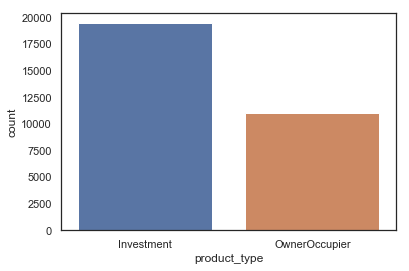

In [337]:
category_view(df.product_type);

count   16912.000
mean        2.107
std         0.880
min         1.000
25%         1.000
50%         2.000
75%         3.000
max        33.000
Name: state, dtype: float64
[nan  3.  1.  2.  4. 33.]
number of categories:  6


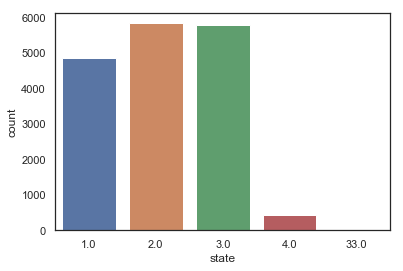

In [338]:
category_view(df.state);

### Data Quality Checks
we have a lot of column names, with im sure plenty of missing or incorrectly formatted values. 


In [339]:
fake = pd.DataFrame(df.isnull().sum())
fake[fake[0].values > 0]

0
life_sq                                6383
floor                                   167
max_floor                              9572
material                               9572
build_year                            13605
num_room                               9572
kitch_sq                               9572
state                                 13559
preschool_quota                        6688
school_quota                           6685
hospital_beds_raion                   14441
raion_build_count_with_material_info   4991
build_count_block                      4991
build_count_wood                       4991
build_count_frame                      4991
build_count_brick                      4991
build_count_monolith                   4991
build_count_panel                      4991
build_count_foam                       4991
build_count_slag                       4991
build_count_mix                        4991
raison_build_count_info                4991
build_count_before_1920                4991
build_count_1921-1945                  4991
build_count_1946-1970                  4991
build_count_1971-1995                  4991
build_count_after_1995                 4991
metro_min_walk                           25
metro_km_walk                            25
railroad_station_walk_km                 25
railroad_station_walk_min                25
ID_railroad_station_walk                 25
cafe_sum_500_min_price_avg            13281
cafe_sum_500_max_price_avg            13281
cafe_avg_price_500                    13281
cafe_sum_1000_min_price_avg            6524
cafe_sum_1000_max_price_avg            6524
cafe_avg_price_1000                    6524
cafe_sum_1500_min_price_avg            4199
cafe_sum_1500_max_price_avg            4199
cafe_avg_price_1500                    4199
cafe_sum_2000_min_price_avg            1725
cafe_sum_2000_max_price_avg            1725
cafe_avg_price_2000                    1725
cafe_sum_3000_min_price_avg             991
cafe_sum_3000_max_price_avg             991
cafe_avg_price_3000                     991
prom_part_5000                          178
cafe_sum_5000_min_price_avg             297
cafe_sum_5000_max_price_avg             297
cafe_avg_price_5000                     297
price_doc                              5000

### Apartment Size Analysis

In [340]:
sns.lmplot(x ='full_sq', y = 'life_sq', data = df, hue = 'product_type', 
           ci = None, markers=["o", "x"])

There appears to be several outliers with `full_sq` and `life_sq`

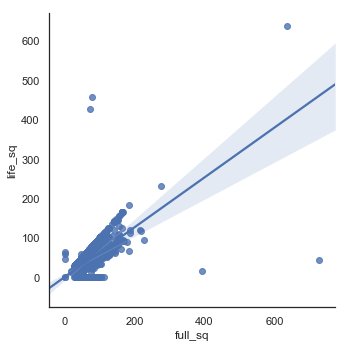

In [341]:
sns.lmplot(x ='full_sq', y = 'life_sq', data = df[(df.floor > 10) & (df.full_sq < 5000)])

In [342]:
sns.lmplot(x ='full_sq', y = 'area_m', data = df[(df.floor > 10) & (df.full_sq < 5000)])

#### Apartment Size Anlaysis Final Outcomes
* Change `id: 3530` `full_sq: 5326` appears an outlier but really an input error, we believe this apt appars to be on the same floor as `id: 4184` given all the similar neighbourhood features. Therefore, `id: 3530` will be updated to `full_sq: 52`
* Remove `id: 13549` as the `life_sq: 7478` is an outlier, but after futher anysis appeared to be missed keyed. We changed this to a `NaN` value which was then made to be a canidate for median imputation

In [343]:
# updated features
df.loc[df.id==3530, "full_sq"] = 52
df.loc[df.id==13549, "life_sq"] = np.nan

##### Mediuam Imputation 
Create function to fill in missing values by grouping similar groups and taking the mediaum of the targeted column. 

In [344]:
def median_impute(data):
    return data.fillna(data.median())

In [345]:
# compute the nearest 10s for full_sq for life_sq imputations for NAs
df['full_sq10'] = (df.full_sq // 10) * 10

In [346]:
# group by sub area and the nears10s full sq
by_area_sq = df.groupby(['sub_area', 'full_sq10'])
by_area = df.groupby(['sub_area'])
by_sq = df.groupby(['full_sq10'])
df.life_sq = by_area_sq.life_sq.transform(median_impute)
df.life_sq = by_area.life_sq.transform(median_impute)
df.life_sq = by_sq.life_sq.transform(median_impute)

In [347]:
df.life_sq.isnull().sum()

0

__Median imputation on metro and railroad NA__

In [348]:
# imputation on mean for metro walk and km
df[df.metro_km_walk.isnull()].sub_area.unique()
df[df.metro_km_walk.isnull()].ID_metro.unique()

array([105, 158, 140,  21,  92,  88], dtype=int64)

In [349]:
by_area_metro = df.groupby(['sub_area', 'ID_metro'])
df.metro_km_walk = by_area_metro.metro_km_walk.transform(median_impute)
df.metro_min_walk = by_area_metro.metro_min_walk.transform(median_impute)
df.metro_km_walk.isnull().sum() + df.metro_min_walk.isnull().sum()

0

__STILL WORKING ON TRAIN NAs__

In [350]:
df[df.ID_railroad_station_walk.isnull()].sub_area.unique()

array(['Timirjazevskoe', 'Begovoe', 'Ochakovo-Matveevskoe',
       'Poselenie Vnukovskoe', 'Krylatskoe', 'Vojkovskoe'], dtype=object)

__Cafe Count - Median Impute__

In [351]:
# [col for col in df if col.startswith('cafe_')]
cafe_count_key = ['cafe_count_500','cafe_count_1000', 'cafe_count_1500', 
                  'cafe_count_2000', 'cafe_count_3000','cafe_count_5000']

for cafe_count_key_i in cafe_count_key:
    by_area = df.groupby(['sub_area', cafe_count_key_i])
    
    # list comprehension to create columns that are similar for median impute
    cols_= [col for col in df if col.startswith(cafe_count_key_i +"_")]
    
    for col_var in cols_:
        df[col_var] = by_area[col_var].transform(median_impute)
        

TBD SECTION Still have some cafe NULL items.. considering removing... not needed. 

In [352]:
cafe_avg_keys ={'cafe_avg_price_500': ['cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg'],
                'cafe_avg_price_1000': ['cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg'],
                'cafe_avg_price_1500':['cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg'],
                'cafe_avg_price_2000': ['cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg'],
                'cafe_avg_price_3000': ['cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg'],
                'cafe_avg_price_5000': ['cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg']}

Remaining features that have `NA` values... we will still include them in the correlation analysis in case we need to make some correection, but from the look of it, we will already have multicolinarity assessments to perform. 

In [353]:
fake = pd.DataFrame(df.isnull().sum())
print(fake[fake[0].values > 0])

                                          0
floor                                   167
max_floor                              9572
material                               9572
build_year                            13605
num_room                               9572
kitch_sq                               9572
state                                 13559
preschool_quota                        6688
school_quota                           6685
hospital_beds_raion                   14441
raion_build_count_with_material_info   4991
build_count_block                      4991
build_count_wood                       4991
build_count_frame                      4991
build_count_brick                      4991
build_count_monolith                   4991
build_count_panel                      4991
build_count_foam                       4991
build_count_slag                       4991
build_count_mix                        4991
raison_build_count_info                4991
build_count_before_1920         

#### VARIABLES EDA DECISONS

* Removing `floor`, `max_floor`, `materials`, `build_year`, `num_rooms`,`state` as there is not enough information for imputation. even with a multiple linear regression, for potential predictions, the results accuracy would need to at least by reviewed by someone from SBER Bank. 
* __`kitch_sq`__ dropped - inaccuracys such as - `ID: 8059` where `full_sq` and `life_sq` = 11 but `kitch_sq` = 12

In [354]:
df[df.id == 8059][['id', 'timestamp','full_sq', 'life_sq', 'kitch_sq']]

id  timestamp  full_sq  life_sq  kitch_sq
6720  8059      41415       11   11.000    12.000

looking at the `sub_area` distribution, most of them come from the `Poselenie` neighborhood - these are great canadiated for developing new features. TBD

## EDA QUESTIONS:
1. Whats up with `metro_min_walk` `id: 21485`? `sub_area: Nagornoe` - outlier

---
# Feature Engineering

### Categorical Features

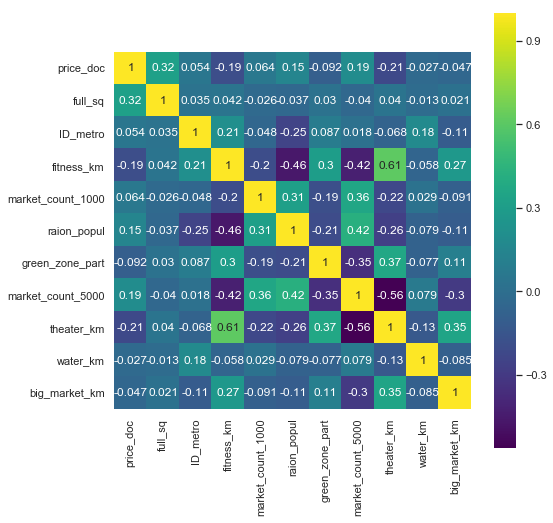

In [355]:
columns = ['price_doc','full_sq','ID_metro', 'fitness_km', 'market_count_1000', 'raion_popul', 'green_zone_part',
          'market_count_5000', 'theater_km', 'water_km', 'big_market_km']

corr_matrix = train[columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')

In [356]:
columns = ['price_doc','full_sq','kremlin_km','culture_objects_top_25_raion', 'market_count_1000', 'shopping_centers_raion',
          'market_count_5000', 'theater_km', 'water_km','water_treatment_km' , 'big_market_km', 'nuclear_reactor_raion', 
          'detention_facility_raion', 'water_treatment_km', 'big_church_km', 'big_market_km', 'market_shop_km',
          'shopping_centers_raion', 'office_raion']

"""
'raion_popul'
'ID_metro'
"""

corr_matrix = train[columns].corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr_matrix, vmax=.8, square=True, annot=True, cmap='viridis')

In [357]:
all_data = pd.concat([df, pd.get_dummies(df[['product_type', 'sub_area', 'culture_objects_top_25',
                                            'shopping_centers_raion', 'big_market_raion']])], axis=1)
all_data.head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1      40775       43   27.000  4.000        nan       nan         nan   
1   2      40778       34   19.000  3.000        nan       nan         nan   
2   3      40782       43   29.000  2.000        nan       nan         nan   
3   4      40787       89   50.000  9.000        nan       nan         nan   
4   5      40791       77   77.000  4.000        nan       nan         nan   

   num_room  kitch_sq  state product_type           sub_area       area_m  \
0       nan       nan    nan   Investment           Bibirevo  6407578.100   
1       nan       nan    nan   Investment  Nagatinskij Zaton  9589336.912   
2       nan       nan    nan   Investment     Tekstil'shhiki  4808269.831   
3       nan       nan    nan   Investment             Mitino 12583535.690   
4       nan       nan    nan   Investment          Basmannoe  8398460.622   

   raion_popul  green_zone_part  indust_part  children_preschool  \
0       155572            0.190        0.000                9576   
1       115352            0.373        0.050                6880   
2       101708            0.113        0.119                5879   
3       178473            0.195        0.070               13087   
4       108171            0.015        0.037                5706   

   preschool_quota  prek_raison  children_school  school_quota  \
0         5001.000            5            10309     11065.000   
1         3119.000            5             7759      6237.000   
2         1463.000            4             6207      5580.000   
3         6839.000            9            13670     17063.000   
4         3240.000            7             6748      7770.000   

   school_education_centers_raion  school_top20_raison  hospital_beds_raion  \
0                               5                    0              240.000   
1                               8                    0              229.000   
2                               7                    0             1183.000   
3                              10                    0                  nan   
4                               9                    0              562.000   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   
1                         1                        0                    6   
2                         1                        0                    5   
3                         1                        0                   17   
4                         4                        2                   25   

   additional_education_raion culture_objects_top_25  \
0                           3                     no   
1                           1                    yes   
2                           1                     no   
3                           6                     no   
4                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   
3                        no                 no                  no   
4                        no                 no                  no   

  radiation_raion railroad_terminal_raion big_market_raion  \
0              no                      no               no   
1     

In [358]:
df.sub_area.unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe',
       'Lefortovo', "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo",
       'Vnukovo', 'Juzhnoe Tushino', 'Severnoe Tushino',
       "Chertanovo Central'noe", 'Otradnoe', 'Novo-Peredelkino',
       'Bogorodskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Ljublino', 'Caricyno', 'Veshnjaki', 'Danilovskoe',
       'Preobrazhenskoe', "Kon'kovo", 'Brateevo', 'Vostochnoe Izmajlovo',
       'Jaroslavskoe', 'Vyhino-Zhulebino', 'Donskoe', 'Novogireevo',
       'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Taganskoe', 'Dmitrovskoe', 'Orehovo-Borisovo Juzhnoe',
       'Teplyj Stan', 'Babushkinskoe', 'Staroe Krjukovo',
       'Pokrovskoe Streshnevo', 'Obruchevskoe', 'Filevskij Park',
       'Tropar

### Correlation Analysis
* `life_sq` was correlated with `full_sq` and `full_sq` is more correlated with price. `fill_sq` kept.


In [ ]:
potentialFeatures = p

In [365]:
df.head()

id  timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1      40775       43   27.000  4.000        nan       nan         nan   
1   2      40778       34   19.000  3.000        nan       nan         nan   
2   3      40782       43   29.000  2.000        nan       nan         nan   
3   4      40787       89   50.000  9.000        nan       nan         nan   
4   5      40791       77   77.000  4.000        nan       nan         nan   

   num_room  kitch_sq  state product_type           sub_area       area_m  \
0       nan       nan    nan   Investment           Bibirevo  6407578.100   
1       nan       nan    nan   Investment  Nagatinskij Zaton  9589336.912   
2       nan       nan    nan   Investment     Tekstil'shhiki  4808269.831   
3       nan       nan    nan   Investment             Mitino 12583535.690   
4       nan       nan    nan   Investment          Basmannoe  8398460.622   

   raion_popul  green_zone_part  indust_part  children_preschool  \
0       155572            0.190        0.000                9576   
1       115352            0.373        0.050                6880   
2       101708            0.113        0.119                5879   
3       178473            0.195        0.070               13087   
4       108171            0.015        0.037                5706   

   preschool_quota  prek_raison  children_school  school_quota  \
0         5001.000            5            10309     11065.000   
1         3119.000            5             7759      6237.000   
2         1463.000            4             6207      5580.000   
3         6839.000            9            13670     17063.000   
4         3240.000            7             6748      7770.000   

   school_education_centers_raion  school_top20_raison  hospital_beds_raion  \
0                               5                    0              240.000   
1                               8                    0              229.000   
2                               7                    0             1183.000   
3                              10                    0                  nan   
4                               9                    0              562.000   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   
1                         1                        0                    6   
2                         1                        0                    5   
3                         1                        0                   17   
4                         4                        2                   25   

   additional_education_raion culture_objects_top_25  \
0                           3                     no   
1                           1                    yes   
2                           1                     no   
3                           6                     no   
4                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   
3                        no                 no                  no   
4                        no                 no                  no   

  radiation_raion railroad_terminal_raion big_market_raion  \
0              no                      no               no   
1     

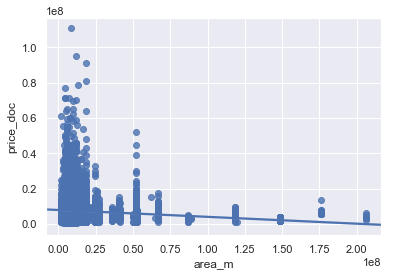

In [228]:
sns.regplot(x='area_m',
               y='price_doc',
               data = df)

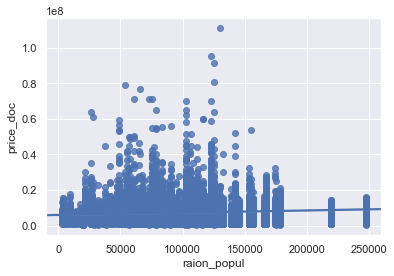

In [229]:
sns.regplot(x='raion_popul',
               y='price_doc',
               data = df)

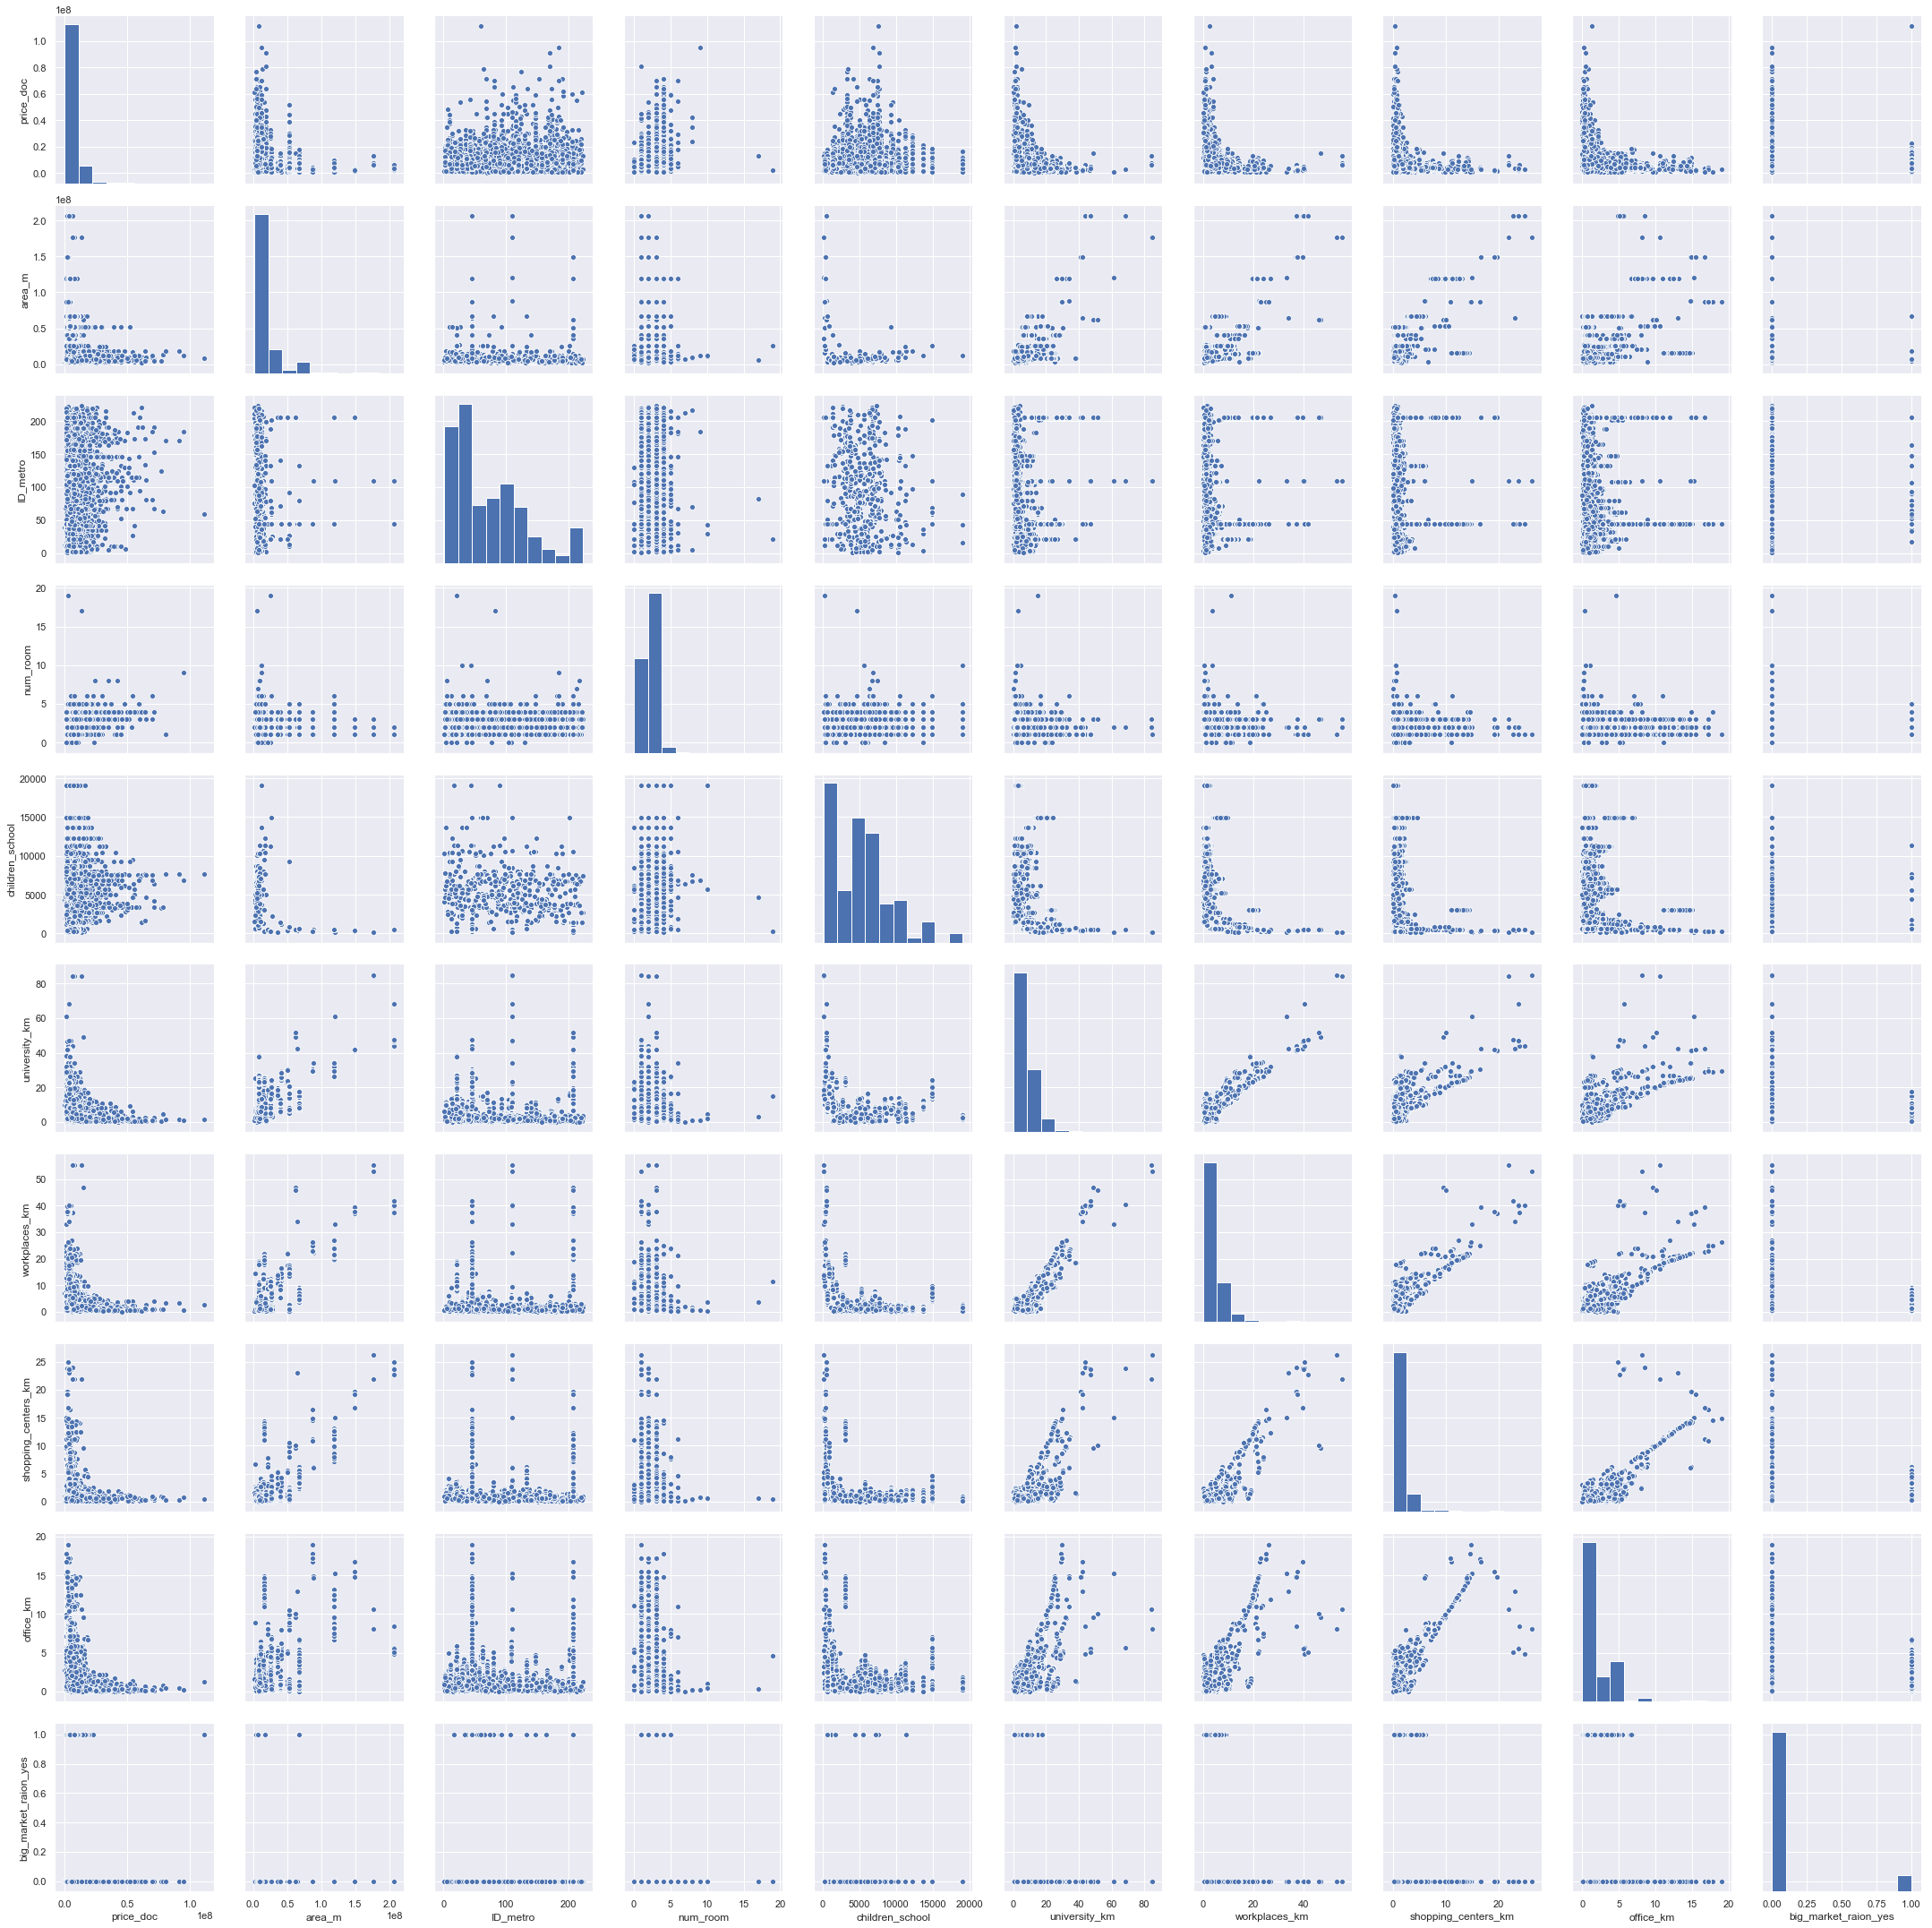

In [258]:
sns.set()
columns = ['price_doc','product_type', 'sub_area', 'area_m', 'ID_metro','num_room','children_school',
           'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', 'big_market_raion_yes']

sns.pairplot(all_data[columns], size = 3, kind = 'scatter')
plt.show()

In [ ]:
sns.set()
columns = ['price_doc','product_type', 'sub_area', 'area_m', 'ID_metro','num_room','children_school',
           'university_km', 'workplaces_km', 'shopping_centers_km', 'office_km', ]

sns.pairplot(all_data[columns], size = 3, kind = 'scatter')
plt.show()

['floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'preschool_quota',
 'school_quota',
 'hospital_beds_raion',
 'raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raison_build_count_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'ID_railroad_station_walk',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_

#### SAVE CHECKPOINT DATA FILE

In [371]:
# remove columns with NA values
null_list = pd.DataFrame(df.isnull().sum())
col_to_remove_lazy_EDA = list(null_list[null_list[0].values > 0].index)
df.loc[:, ~df.columns.isin(col_to_remove_lazy_EDA[:-1])].to_csv("df_clean_v2.csv")
df.loc[:, ~df.columns.isin(col_to_remove_lazy_EDA[:-1])].head()
#list(df.loc[:, ~df.columns.isin(col_to_remove_lazy_EDA)].columns)

id  timestamp  full_sq  life_sq product_type           sub_area  \
0   1      40775       43   27.000   Investment           Bibirevo   
1   2      40778       34   19.000   Investment  Nagatinskij Zaton   
2   3      40782       43   29.000   Investment     Tekstil'shhiki   
3   4      40787       89   50.000   Investment             Mitino   
4   5      40791       77   77.000   Investment          Basmannoe   

        area_m  raion_popul  green_zone_part  indust_part  children_preschool  \
0  6407578.100       155572            0.190        0.000                9576   
1  9589336.912       115352            0.373        0.050                6880   
2  4808269.831       101708            0.113        0.119                5879   
3 12583535.690       178473            0.195        0.070               13087   
4  8398460.622       108171            0.015        0.037                5706   

   prek_raison  children_school  school_education_centers_raion  \
0            5            10309                               5   
1            5             7759                               8   
2            4             6207                               7   
3            9            13670                              10   
4            7             6748                               9   

   school_top20_raison  healthcare_centers_raion  university_top_20_raion  \
0                    0                         1                        0   
1                    0                         1                        0   
2                    0                         1                        0   
3                    0                         1                        0   
4                    0                         4                        2   

   sport_objects_raion  additional_education_raion culture_objects_top_25  \
0                    7                           3                     no   
1                    6                           1                    yes   
2                    5                           1                     no   
3                   17                           6                     no   
4                   25                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   
3                        no                 no                  no   
4                        no                 no                  no   

  radiation_raion railroad_terminal_raion big_market_raion  \
0              no                      no               no   
1              no                      no               no   
2             yes                      no               no   
3              no                      no               no   
4             yes                     yes               no   

  nuclear_reactor_raion detention_facility_raion  full_all  male_f  female_f  \
0                    no                       no     86206   40477     45729   
1                    no                       no     76284   34200     42084   
2                    no                       no    101982   46076     55906   
3                    no                       no     21155    9828     11327   
4                    no                       no     28179   13522     14657   

   young_all  young_male  young_female  work_all  wo

In [374]:
#all data
# remove columns with NA values
null_list = pd.DataFrame(all_data.isnull().sum())
col_to_remove_lazy_EDA = list(null_list[null_list[0].values > 0].index)
all_data.loc[:, ~all_data.columns.isin(col_to_remove_lazy_EDA[:-1])].to_csv("df_clean_v2_dummies.csv")
all_data.loc[:, ~all_data.columns.isin(col_to_remove_lazy_EDA[:-1])].head()

id  timestamp  full_sq  life_sq product_type           sub_area  \
0   1      40775       43   27.000   Investment           Bibirevo   
1   2      40778       34   19.000   Investment  Nagatinskij Zaton   
2   3      40782       43   29.000   Investment     Tekstil'shhiki   
3   4      40787       89   50.000   Investment             Mitino   
4   5      40791       77   77.000   Investment          Basmannoe   

        area_m  raion_popul  green_zone_part  indust_part  children_preschool  \
0  6407578.100       155572            0.190        0.000                9576   
1  9589336.912       115352            0.373        0.050                6880   
2  4808269.831       101708            0.113        0.119                5879   
3 12583535.690       178473            0.195        0.070               13087   
4  8398460.622       108171            0.015        0.037                5706   

   prek_raison  children_school  school_education_centers_raion  \
0            5            10309                               5   
1            5             7759                               8   
2            4             6207                               7   
3            9            13670                              10   
4            7             6748                               9   

   school_top20_raison  healthcare_centers_raion  university_top_20_raion  \
0                    0                         1                        0   
1                    0                         1                        0   
2                    0                         1                        0   
3                    0                         1                        0   
4                    0                         4                        2   

   sport_objects_raion  additional_education_raion culture_objects_top_25  \
0                    7                           3                     no   
1                    6                           1                    yes   
2                    5                           1                     no   
3                   17                           6                     no   
4                   25                           2                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   
1                             1                       3             0   
2                             0                       0             1   
3                             0                      11             4   
4                             0                      10            93   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   
1                        no                 no                  no   
2                        no                 no                  no   
3                        no                 no                  no   
4                        no                 no                  no   

  radiation_raion railroad_terminal_raion big_market_raion  \
0              no                      no               no   
1              no                      no               no   
2             yes                      no               no   
3              no                      no               no   
4             yes                     yes               no   

  nuclear_reactor_raion detention_facility_raion  full_all  male_f  female_f  \
0                    no                       no     86206   40477     45729   
1                    no                       no     76284   34200     42084   
2                    no                       no    101982   46076     55906   
3                    no                       no     21155    9828     11327   
4                    no                       no     28179   13522     14657   

   young_all  young_male  young_female  work_all  wo

In [105]:
df['log_price'] = np.log(train.price_doc)

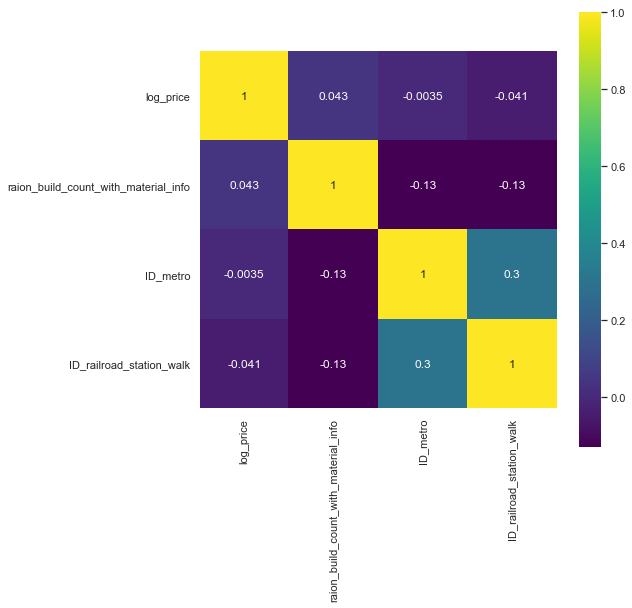

In [106]:
columns = ['log_price','raion_build_count_with_material_info', 'ID_metro', 'ID_railroad_station_walk']

corr_matrix = df[columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')

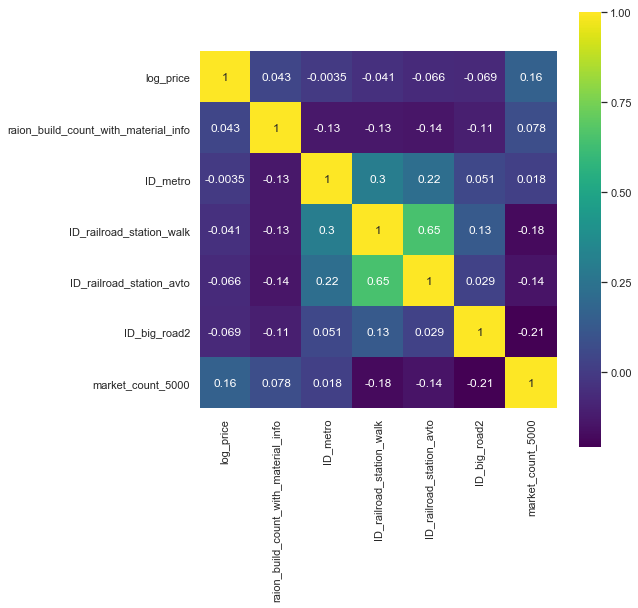

In [108]:
columns = ['log_price','raion_build_count_with_material_info', 'ID_metro', 'ID_railroad_station_walk', 
           'ID_railroad_station_avto', 'ID_big_road2', 'market_count_5000']

corr_matrix = df[columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')

C:\Users\phhale\AppData\Local\Continuum\anaconda3\envs\bril\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


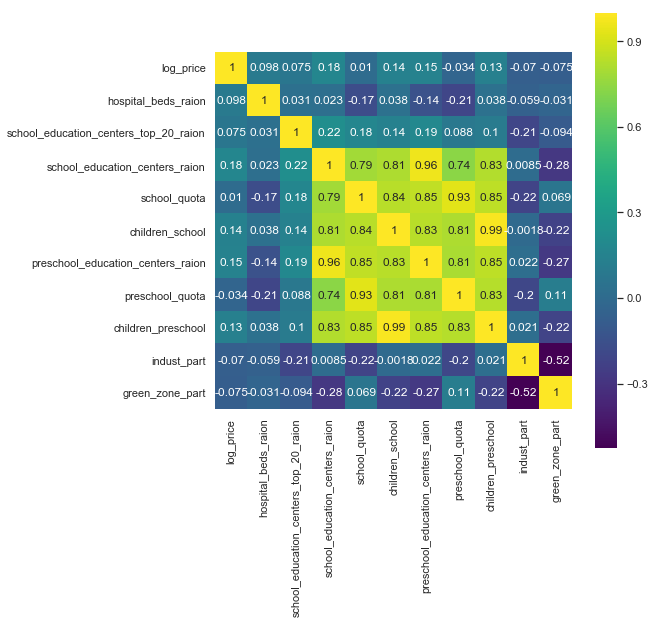

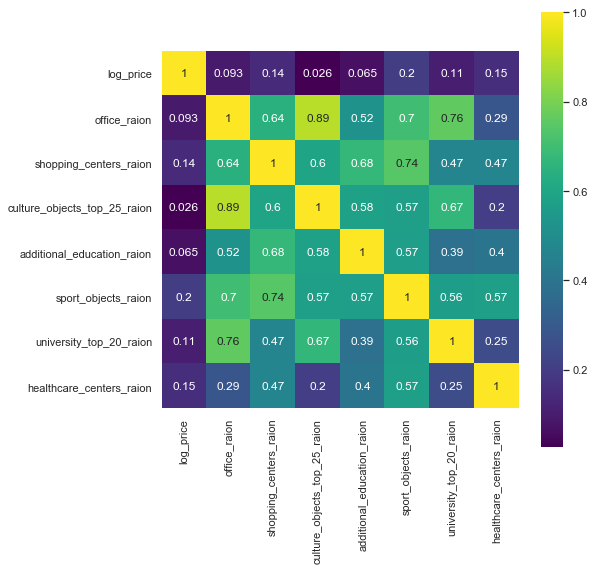

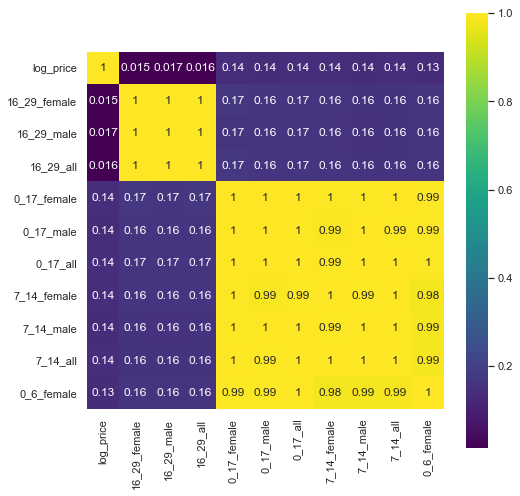

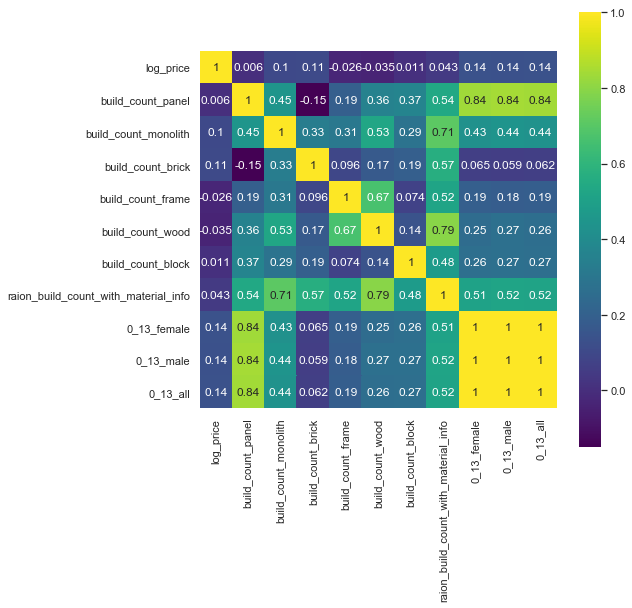

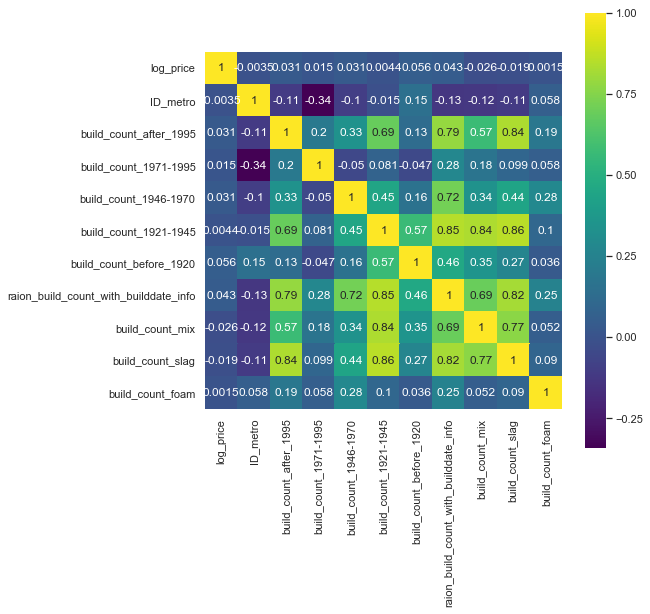

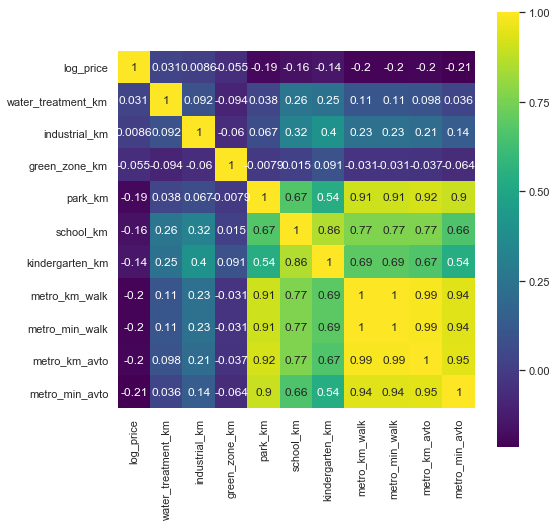

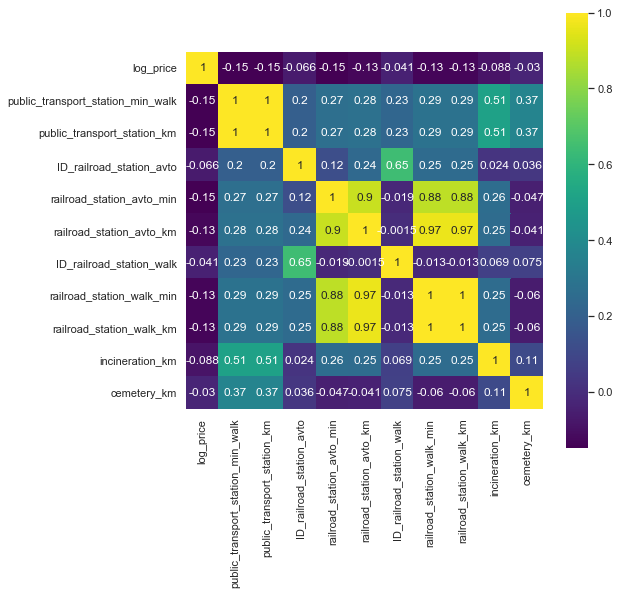

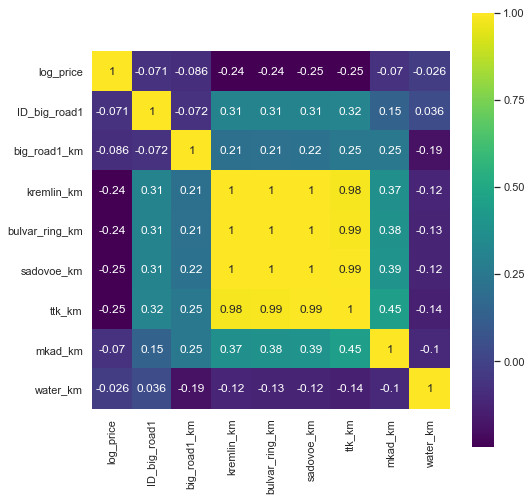

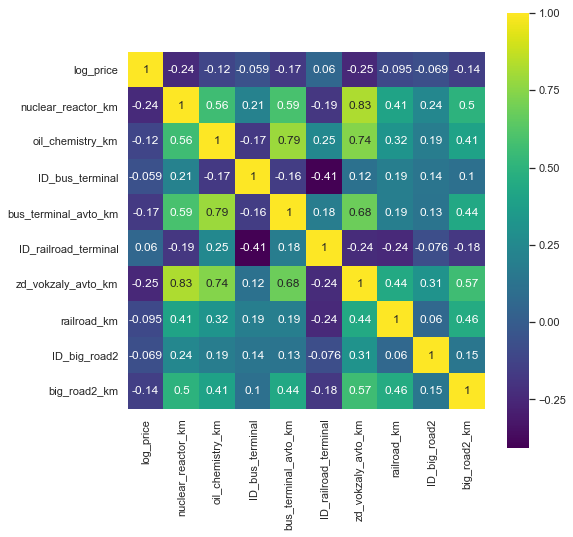

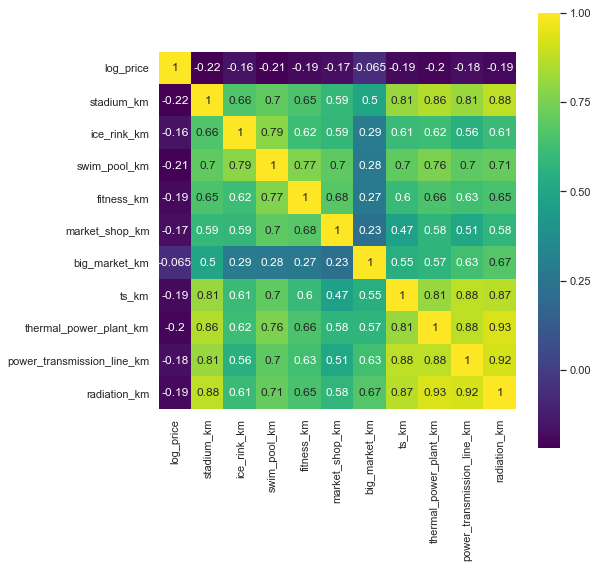

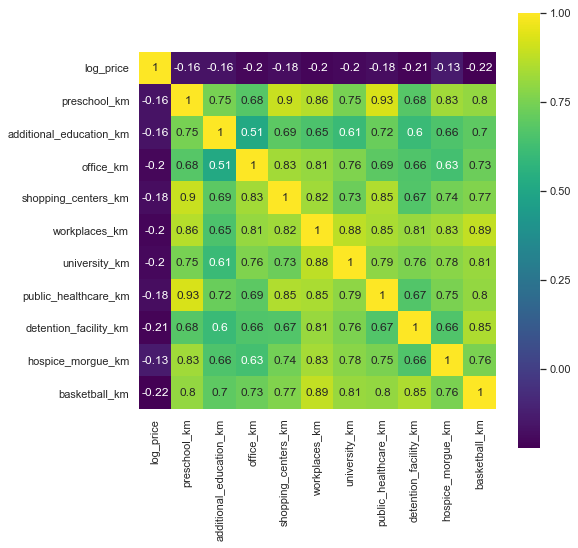

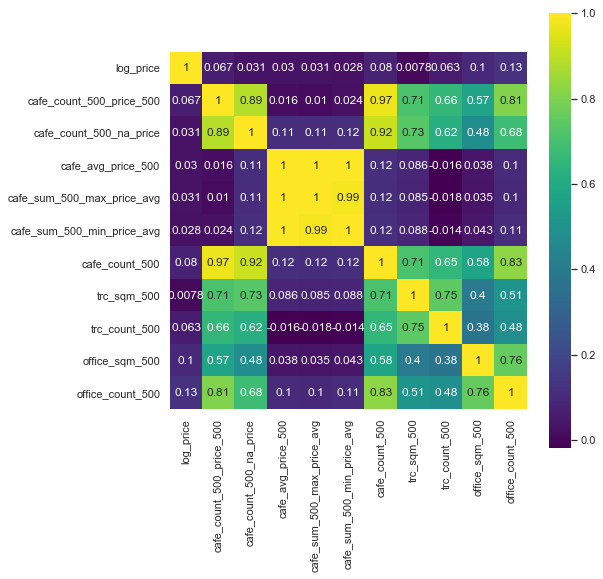

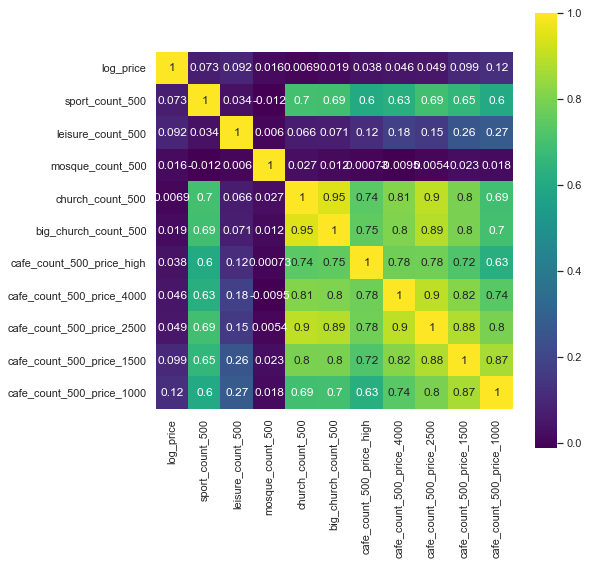

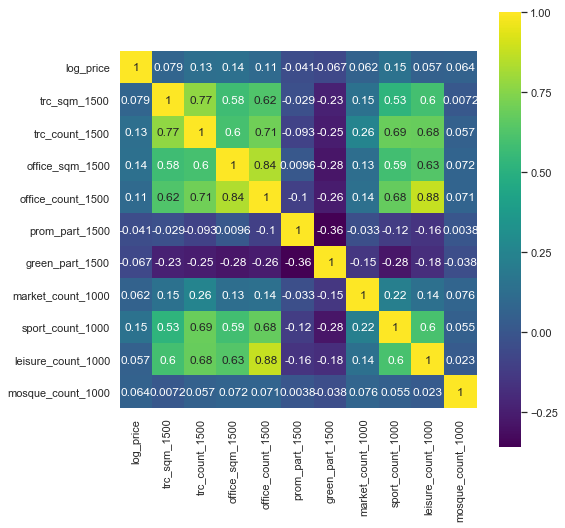

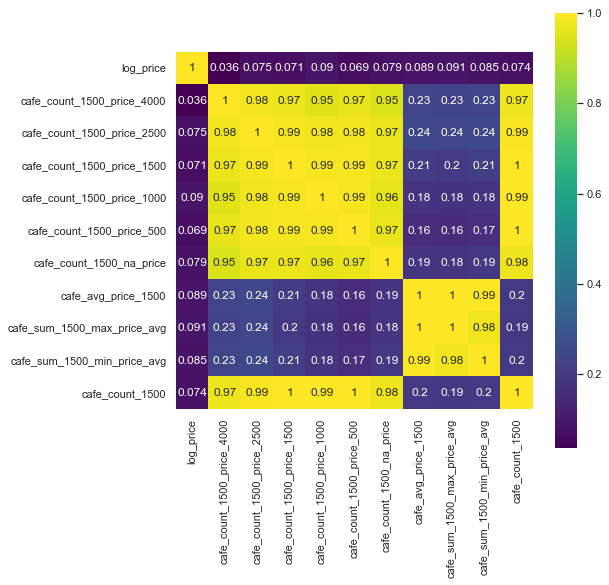

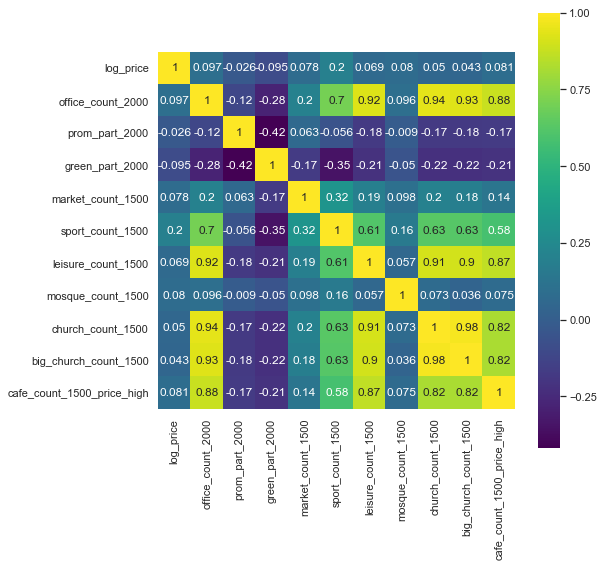

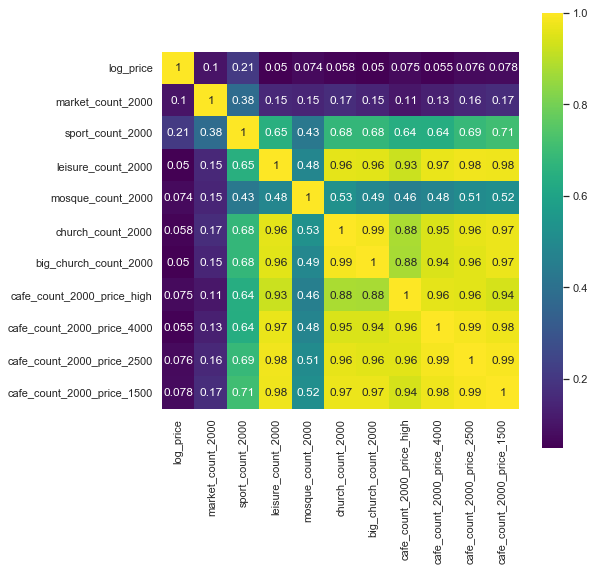

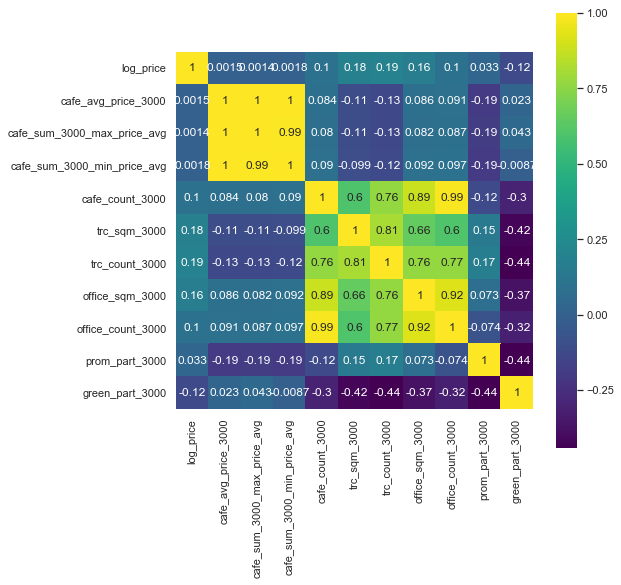

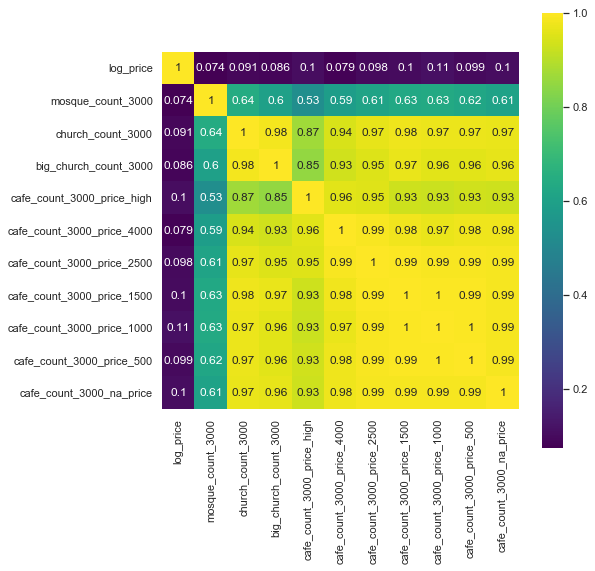

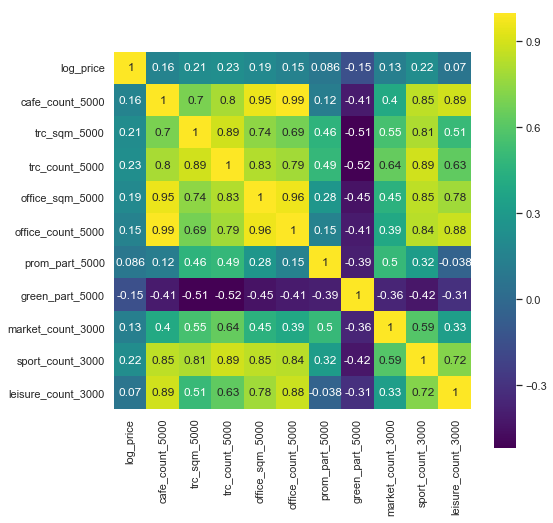

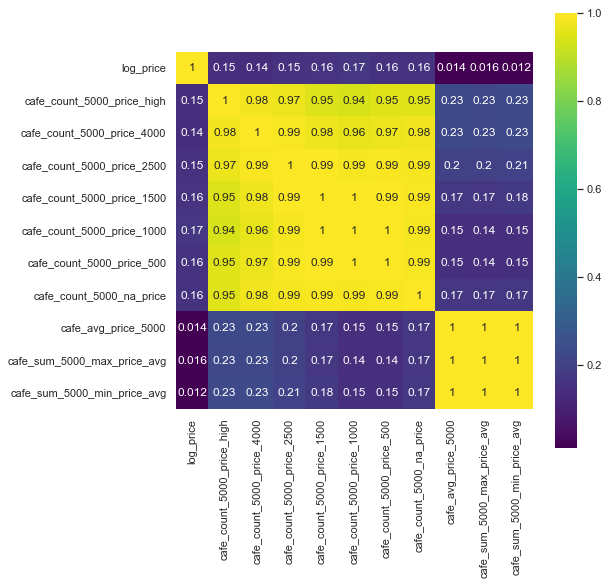

In [110]:
def corr_matrix(i):
    # only quanitiative variables (hard to tall if qualitative predictors are correlatied)
    corr_matrix = df[['log_price', df.columns[i-1],df.columns[i-2],df.columns[i-3],df.columns[i-4],df.columns[i-5],
         df.columns[i-6],df.columns[i-7],df.columns[i-8],df.columns[i-9],df.columns[i-10]]].corr()
    plt.figure(figsize=(8,8))
    sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')



k = len(df.columns)
count = 0

for i in range(5, k,10):
    corr_matrix(i)
    count += 1

In [ ]:
metro_min_walk	19
metro_km_walk	19
railroad_station_walk_km	19
railroad_station_walk_min	19
ID_railroad_station_walk

In [ ]:
columns = ['log_price','state', 'product_type', 'sub_area','ID_metro',
           'metro_min_walk', 'metro_km_walk', 'railroad_station_walk_km', 'ID_railroad_station_walk']

corr_matrix = df[columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')

In [ ]:
X = df[['ID_metro', '']]

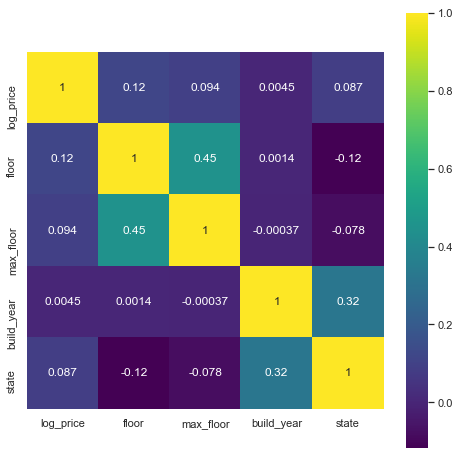

In [129]:
columns = ['log_price','floor', 'max_floor', 'build_year', 
           'state', 'product_type', 'sub_area']

corr_matrix = df[columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')

In [ ]:
df[]

In [184]:
col_to_remove_lazy_EDA = list(fake2[fake2[0].values > 0].index)

In [191]:
col_to_remove_lazy_EDA = list(fake2[fake2[0].values > 0].index)
df.loc[:, ~df.columns.isin(col_to_remove_lazy_EDA)].to_csv("df_clean_v1.csv")
df.loc[:, ~df.columns.isin(col_to_remove_lazy_EDA)].head()
#list(df.loc[:, ~df.columns.isin(col_to_remove_lazy_EDA)].columns)

id  timestamp  full_sq  life_sq product_type           sub_area  \
0   1      40775       43     27.0   Investment           Bibirevo   
1   2      40778       34     19.0   Investment  Nagatinskij Zaton   
2   3      40782       43     29.0   Investment     Tekstil'shhiki   
3   4      40787       89     50.0   Investment             Mitino   
4   5      40791       77     77.0   Investment          Basmannoe   

         area_m  raion_popul  green_zone_part  indust_part  ...  \
0  6.407578e+06       155572         0.189727     0.000070  ...   
1  9.589337e+06       115352         0.372602     0.049637  ...   
2  4.808270e+06       101708         0.112560     0.118537  ...   
3  1.258354e+07       178473         0.194703     0.069753  ...   
4  8.398461e+06       108171         0.015234     0.037316  ...   

   cafe_count_5000_price_high  big_church_count_5000  church_count_5000  \
0                           0                     13                 22   
1                           0                     15                 29   
2                           0                     11                 27   
3                           1                      4                  4   
4                          17                    135                236   

   mosque_count_5000  leisure_count_5000  sport_count_5000  market_count_5000  \
0                  1                   0                52                  4   
1                  1                  10                66                 14   
2                  0                   4                67                 10   
3                  0                   0                26                  3   
4                  2                  91               195                 14   

   price_doc  full_sq10  log_price  
0    5850000         40  15.581952  
1    6000000         30  15.607270  
2    5700000         40  15.555977  
3   13100000         80  16.388123  
4   16331452         70  16.608603  

[5 rows x 244 columns]

['id',
 'timestamp',
 'full_sq',
 'life_sq',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'prek_raison',
 'children_school',
 'school_education_centers_raion',
 'school_top20_raison',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekder_male',
 'ekder_female',
 '0_6_all',
 '0_6_male',
 '0_6_female',
 '7_14_all',
 '7_14_male',
 '7_14_female',
 '0_17_all',
 '0_17_male',
 '0_17_female',
 '16_29_all',
 '16_29_male',


In [111]:
df.to_csv("df_clean.csv")

PermissionError: [Errno 13] Permission denied